# 恶性肿瘤侦测（Histopathologic Cancer Detection)-Kaggle图片分类比赛


传送门 [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)

In [78]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [79]:
from fastai import *
from fastai.vision import *

# 从 Kaggle API 下载数据集

In [80]:
#! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /opt/anaconda3/lib/python3.7/site-packages (1.5.2)


In [81]:
path = Config.data_path()/'cancer'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/cancer')

In [29]:
#! chmod 600 /home/jupyter/.kaggle/kaggle.json

In [30]:
#! kaggle competitions download -c histopathologic-cancer-detection -f train.zip -p {path}
#! kaggle competitions download -c histopathologic-cancer-detection -f train_labels.csv -p {path}
#! kaggle competitions download -c histopathologic-cancer-detection -f test.zip -p {path}

train.zip: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
#! sudo apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [45]:
#! unzip {path}/train.zip -d {path}/train
#! unzip {path}/test.zip -d {path}/test
#! unzip {path}/train_labels.csv.zip -d {path}

In [35]:
# allow the permission of the csv file
#! chmod 600 /home/jupyter/.fastai/data/cancer/train_labels.csv

#  查看并转换数据集

In [82]:
df = pd.read_csv(path/'train_labels.csv')
df.tail()

,id,label
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
220024,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,1


In [83]:
tfms = get_transforms(flip_vert=True, do_flip=True, max_lighting=0.1, max_rotate=0., max_warp=0.)

In [86]:
data = ImageDataBunch.from_csv(path,
                               csv_labels='train_labels.csv',
                               folder='train', 
                               valid_pct = 0.2,
                               ds_tfms=tfms, 
                               size=128, 
                               suffix='.tif',
                               test='test',
                               bs=32).normalize()

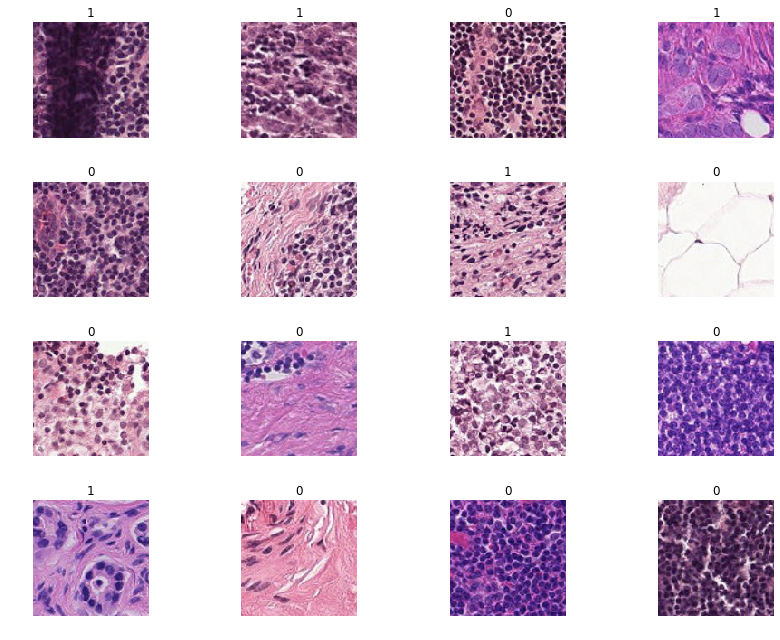

In [87]:
data.show_batch(rows = 4, figsize=(12,9))

In [88]:
from sklearn.metrics import roc_auc_score

# 定义评估指标 AUC_Score (area under the ROC curve)

In [89]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [90]:
learn = create_cnn(data, 
                   models.resnet34, 
                   metrics = [auc_score]
                   )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


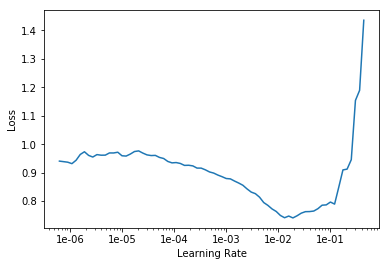

In [91]:
learn.lr_find()
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,auc_score
1,0.312568,0.261496,0.939485
2,0.247462,0.194166,0.972390
3,0.218939,0.176733,0.977886
4,0.216100,0.166127,0.979773
5,0.210834,0.167638,0.980425


# 查看错误的分类预测

In [93]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

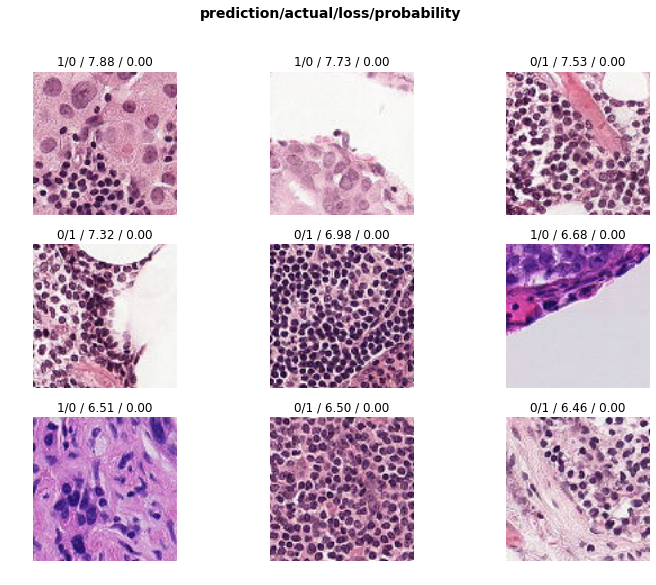

In [94]:
interp.plot_top_losses(9, figsize=(12,9))

# 微调模型

In [95]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


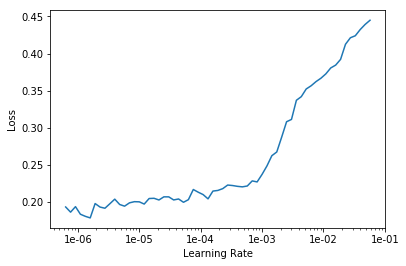

In [96]:
learn.lr_find()
learn.recorder.plot()

In [97]:
learn.fit_one_cycle(5, slice(1e-6, 1e-6/5))

epoch,train_loss,valid_loss,auc_score
1,0.205738,0.165141,0.980720
2,0.192271,0.157798,0.982348
3,0.206930,0.157830,0.982166


KeyboardInterrupt: 

# 增加图片尺寸，放大一倍，继续微调模型

In [110]:
data = ImageDataBunch.from_csv(path,
                               csv_labels='train_labels.csv',
                               folder='train', 
                               valid_pct = 0.2,
                               ds_tfms=tfms, 
                               size=256, 
                               suffix='.tif',
                               test='test',
                               bs=32).normalize()

In [111]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


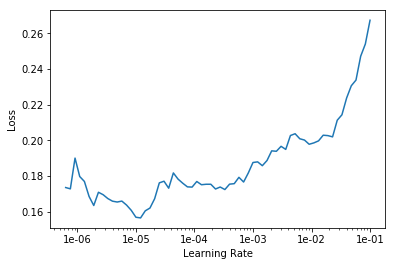

In [112]:
learn.lr_find()
learn.recorder.plot()

In [113]:
learn.fit_one_cycle(2, slice(1e-6))

epoch,train_loss,valid_loss,auc_score
1,0.205016,0.154308,0.982594
2,0.182816,0.154092,0.982951


In [114]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


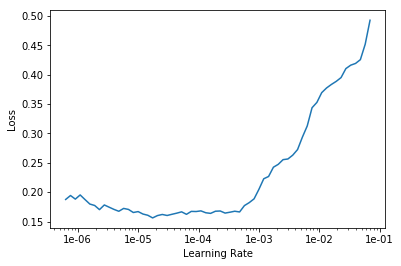

In [115]:
learn.lr_find()
learn.recorder.plot()

In [116]:
learn.fit_one_cycle(2, slice(1e-6, 1e-6/5))

epoch,train_loss,valid_loss,auc_score
1,0.179858,0.151218,0.983314
2,0.195975,0.151677,0.983652


In [117]:
learn.fit_one_cycle(2, slice(1e-6, 1e-6/5))

epoch,train_loss,valid_loss,auc_score
1,0.189955,0.148026,0.984223
2,0.189678,0.146822,0.984427


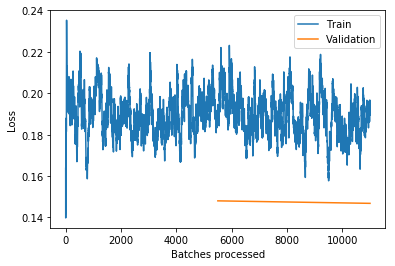

In [118]:
learn.recorder.plot_losses()

# 查看预测示例

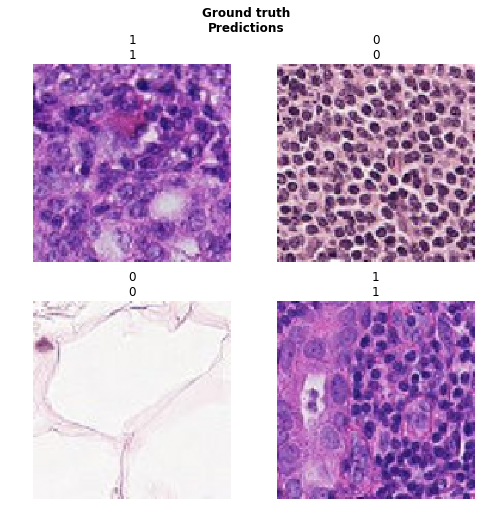

In [122]:
learn.show_results(rows = 2)

In [119]:
preds,y=learn.get_preds()
pred_score=auc_score(preds,y)
pred_score

tensor(0.9852)

In [120]:
preds,y=learn.TTA()
pred_score_tta=auc_score(preds,y)
pred_score_tta

tensor(0.9848)

# 生成预测 submission.csv 文件，并提交至 Kaggle

In [99]:
#! kaggle competitions download -c histopathologic-cancer-detection -f sample_submission.csv -p {path}
#! unzip {path}/sample_submission.csv.zip -d {path}
#! chmod 600 /home/jupyter/.fastai/data/cancer/sample_submission.csv

  0%|                                               | 0.00/1.33M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.33M/1.33M [00:00<00:00, 138MB/s]
Archive:  /home/jupyter/.fastai/data/cancer/sample_submission.csv.zip
  inflating: /home/jupyter/.fastai/data/cancer/sample_submission.csv  


In [123]:
sub = pd.read_csv(f'{path}/sample_submission.csv').set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [124]:
data.test_ds.items[:2]

array([PosixPath('/home/jupyter/.fastai/data/cancer/test/6cab3f4e82613c22f2f2af1821371d4ba488a6d7.tif'),
       PosixPath('/home/jupyter/.fastai/data/cancer/test/ad686e576a5f8ae0379ee54527263f9973ad899b.tif')], dtype=object)

In [125]:
clean_fname = np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned = clean_fname(data.test_ds.items)
fname_cleaned = fname_cleaned.astype(str)

In [126]:
preds_test,y_test=learn.get_preds(ds_type=DatasetType.Test)

In [127]:
sub.loc[fname_cleaned,'label']=to_np(preds_test[:,1])
sub.to_csv(path/'submission.csv')

In [128]:
! kaggle competitions submit -c histopathologic-cancer-detection -f {path/'submission.csv'} -m "My submission 2"

100%|██████████████████████████████████████| 2.87M/2.87M [00:01<00:00, 2.54MB/s]
Successfully submitted to Histopathologic Cancer Detection

# Kaggle得分

Public Score ：0.9555

Rank:293

Top:55%

# 参考


https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb

https://askubuntu.com/questions/86849/how-to-unzip-a-zip-file-from-the-terminal

https://www.jianshu.com/p/c61ae11cc5f6

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html